# Transverse-Field Ising Model Ground State with Symmetric VQE

The experiment targets the ground state of the Transverse-Field Ising Model (TFIM) with periodic boundary conditions.

**Hamiltonian**: The cost function to minimize is the expectation value of:

$$H_{TFIM} = -\sum_{i=1}^{N} Z_i Z_{i+1} - g \sum_{i=1}^{N} X_i$$

where $g > 0$ is the transverse field strength.

**Symmetry ($P$)**: The Hamiltonian respects a $\mathbb{Z}_2$ parity symmetry generated by the global spin flip operator:

$$P = \prod_{i=1}^{N} X_i$$

For $g > 0$, the ground state lies in the +1 parity sector ($P|\psi\rangle = +|\psi\rangle$).





**Symmetry Properties**

1. Commutation: $[H, P] = 0$. The Hamiltonian conserves parity.

2. Action: $P$ flips all spins in the Z-basis ($Z \to -Z$) but leaves the X-basis invariant ($X \to X$).

3. Ground State Sector: For the ferromagnetic TFIM ($g=1$), the ground state lies in the $+1$ parity sector ($P|\psi\rangle = +|\psi\rangle$).


**Consequence for Gates**

To maintain this symmetry, every gate $U$ in the ansatz must commute with $P$ ($[U, P] = 0$).

- Allowed: $R_X(\theta)$ and $R_{ZZ}(\theta)$ (Equivariant).

- Forbidden: $R_Y(\theta)$ and $R_Z(\theta)$ (Break symmetry because they anti-commute with $P$).

In [ ]:
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
np.random.seed(42)

## The Ansatz Strategies

To test the effect of symmetry, the paper compares two variational circuits (ansätze) starting from the symmetric initial state $|\psi_0\rangle = |+\rangle^{\otimes N}$.

**A. Equivariant Ansatz (QAOA)**

This ansatz respects the symmetry. It is constructed using only gates that commute with the parity operator $P$ (specifically $X$ rotations and $ZZ$ interactions).

$$|\psi_{QAOA}(\beta, \gamma)\rangle = \prod_{m=1}^{p} \left( \prod_{i=1}^{N} e^{-i\beta_m X_i} \prod_{i=1}^{N} e^{-i\gamma_m Z_i Z_{i+1}} \right) |\psi_0\rangle$$

Code Implementation: Use layers of qml.IsingZZ (or CNOT-RZ-CNOT) and qml.RX.



In [3]:
N_QUBITS = 10
G_FIELD = 1.0  # Transverse field g=1 (Critical point)

def create_tfim_hamiltonian(n_qubits, g):
    coeffs = []
    ops = []
    
    # ZZ interaction (Periodic BC)
    for i in range(n_qubits):
        coeffs.append(-1.0)
        ops.append(qml.PauliZ(i) @ qml.PauliZ((i + 1) % n_qubits))
    
    # Transverse field X
    for i in range(n_qubits):
        coeffs.append(-g)
        ops.append(qml.PauliX(i))
        
    return qml.Hamiltonian(coeffs, ops)

H_tfim = create_tfim_hamiltonian(N_QUBITS, G_FIELD)


## Exact Ground State (for reference)

In [4]:
def get_ground_state_energy(n_qubits, g=1.0):
    """Calculates exact ground state energy for benchmarking."""
    H = create_tfim_hamiltonian(n_qubits, g)
    # Use sparse method for N=10 efficiency
    H_mat = qml.matrix(H)
    # We only need the lowest eigenvalue
    evals = jnp.linalg.eigvalsh(H_mat)
    return float(evals[0])

## VQE Circuits

In [5]:
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="jax")
def equivariant_qaoa(params, n_qubits):
    """
    Equivariant QAOA Ansatz (Eq. 97).
    Respects Z2 Parity Symmetry.
    """
    # 1. Initial State: |+>^N (Parity +1)
    for q in range(n_qubits):
        qml.Hadamard(wires=q)
        
    p_layers = params.shape[0]
    
    for m in range(p_layers):
        beta, gamma = params[m, 0], params[m, 1]
        
        # ZZ Interaction (Commutes with Parity)
        for q in range(n_qubits):
            qml.IsingZZ(2 * gamma, wires=[q, (q + 1) % n_qubits])
            
        # X Mixer (Commutes with Parity)
        for q in range(n_qubits):
            qml.RX(2 * beta, wires=q)
            
    H = create_tfim_hamiltonian(n_qubits, 1.0)
    return qml.expval(H)



**B. Non-Equivariant Ansatz (QAOA')**

This ansatz breaks the symmetry by adding an extra mixer layer of Pauli-$Y$ rotations.

$$|\psi_{QAOA'}(\alpha, \beta, \gamma)\rangle = \prod_{m=1}^{p} \left( \prod_{i=1}^{N} e^{-i\alpha_m Y_i} \prod_{i=1}^{N} e^{-i\beta_m X_i} \prod_{i=1}^{N} e^{-i\gamma_m Z_i Z_{i+1}} \right) |\psi_0\rangle$$


Code Implementation: Add a qml.RY layer to the standard QAOA structure.


The paper argues that applying the gate symmetrization procedure to the Non-Equivariant ansatz effectively removes the $Y$ rotations. As the parity operator $P$ anti-commutes with $Y$ ($P Y_i P = -Y_i$). Therefore the symmetrization integral (twirling) trivializes these generators to zero, reducing QAOA' back to the standard QAOA.

In [6]:
@qml.qnode(dev, interface="jax")
def nonequivariant_qaoa(params, n_qubits):
    """
    Non-Equivariant QAOA' Ansatz (Eq. 98).
    Includes Y rotations that BREAK Parity Symmetry.
    """
    # 1. Initial State: |+>^N
    for q in range(n_qubits):
        qml.Hadamard(wires=q)
        
    p_layers = params.shape[0]
    
    for m in range(p_layers):
        alpha, beta, gamma = params[m, 0], params[m, 1], params[m, 2]
        
        # ZZ Interaction
        for q in range(n_qubits):
            qml.IsingZZ(2 * gamma, wires=[q, (q + 1) % n_qubits])
            
        # X Mixer
        for q in range(n_qubits):
            qml.RX(2 * beta, wires=q)
            
        # Y Rotation (Symmetry Breaking)
        for q in range(n_qubits):
            qml.RY(2 * alpha, wires=q)
            
    H = create_tfim_hamiltonian(n_qubits, 1.0)
    return qml.expval(H)

## Training

In [7]:
def run_experiment(circuit_fn, n_qubits, p_layers, n_reps=10, max_steps=1000, tol=1e-5):
    """
    High-performance implementation using vmap (parallel reps) and scan (compiled loop).
    Returns: (mean_energy, std_energy, mean_iterations)
    """
    # Determine Parameter Shape
    # Equivariant: (p, 2) | Non-Equivariant: (p, 3)
    cols = 2 if circuit_fn == equivariant_qaoa else 3
    param_shape = (n_reps, p_layers, cols)
        
    optimizer = optax.adam(learning_rate=0.01)
    
   # Define Single Step (Unbatched)
    # We capture 'n_qubits' from the outer scope as a constant integer to avoid Tracer errors.
    def single_step_fn(carry, _):
        params, opt_state = carry
        
        # Define loss with fixed n_qubits for this specific call
        def loss_fn(p):
            return circuit_fn(p, n_qubits)
            
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), loss

    #  Vectorize over repetitions (n_reps)
    # in_axes=(0, 0) means we expect batched params and batched opt_state
    vmapped_step = jax.vmap(single_step_fn, in_axes=((0, 0), None))

    # Compile the entire training loop (Scan)
    @jax.jit
    def optimize_circuit(init_params, init_opt_state):
        """Instead of a Python for loop communicating with the GPU 1000 times (1000 round-trips), 
        the entire loop is compiled into a single XLA kernel. The Python interpreter only fires once.   """
        # carry is (batched_params, batched_opt_state)
        final_carry, history = jax.lax.scan(vmapped_step, (init_params, init_opt_state), None, length=max_steps)
        return history  # Shape: (max_steps, n_reps)

    #  Initialization (Batched)
    print(f"Compiling & Running {circuit_fn.__name__} (N={n_qubits}, p={p_layers})...")
    key = jax.random.PRNGKey(42 + p_layers * 100 + n_qubits)
    init_params = jax.random.normal(key, param_shape) * 0.1
    init_opt_state = jax.vmap(optimizer.init)(init_params)

    #  Execute 
    loss_history = optimize_circuit(init_params, init_opt_state)
    
    # Post-Process results on CPU (Convergence Check)
    # loss_history shape: [steps, n_reps]
    loss_history_np = np.array(loss_history)
    final_energies = []
    iterations_list = []
    
    for rep in range(n_reps):
        trace = loss_history_np[:, rep]
        final_energies.append(trace[-1])
        
        # Calculate convergence: first step where |loss[t] - loss[t-1]| < tol
        diffs = np.abs(np.diff(trace))
        converged_indices = np.where(diffs < tol)[0]
        if len(converged_indices) > 0:
            iterations_list.append(converged_indices[0] + 1)
        else:
            iterations_list.append(max_steps)
            
    return np.mean(final_energies), np.std(final_energies), np.mean(iterations_list)

## Experiments

In [8]:
N_EXPERIMENT = 10
P_VALUES = [2, 4, 6, 8, 10, 12] 
GS_ENERGY = get_ground_state_energy(N_EXPERIMENT)

print(f"Target Ground State Energy (N={N_EXPERIMENT}): {GS_ENERGY:.4f}\n")

data_eq = {"energy": [], "std": [], "iters": []}
data_neq = {"energy": [], "std": [], "iters": []}

for p in P_VALUES:
    # Equivariant 
    e_mean, e_std, iter_mean = run_experiment(equivariant_qaoa, N_EXPERIMENT, p, n_reps=10)
    data_eq["energy"].append(e_mean)
    data_eq["std"].append(e_std)
    data_eq["iters"].append(iter_mean)
    

Target Ground State Energy (N=10): -12.7849

Compiling & Running equivariant_qaoa (N=10, p=2)...
Compiling & Running equivariant_qaoa (N=10, p=4)...
Compiling & Running equivariant_qaoa (N=10, p=6)...
Compiling & Running equivariant_qaoa (N=10, p=8)...
Compiling & Running equivariant_qaoa (N=10, p=10)...
Compiling & Running equivariant_qaoa (N=10, p=12)...


In [9]:
for p in P_VALUES:
    # Non-Equivariant 
    e_mean, e_std, iter_mean = run_experiment(nonequivariant_qaoa, N_EXPERIMENT, p, n_reps=10)
    data_neq["energy"].append(e_mean)
    data_neq["std"].append(e_std)
    data_neq["iters"].append(iter_mean)

Compiling & Running nonequivariant_qaoa (N=10, p=2)...
Compiling & Running nonequivariant_qaoa (N=10, p=4)...
Compiling & Running nonequivariant_qaoa (N=10, p=6)...
Compiling & Running nonequivariant_qaoa (N=10, p=8)...
Compiling & Running nonequivariant_qaoa (N=10, p=10)...
Compiling & Running nonequivariant_qaoa (N=10, p=12)...


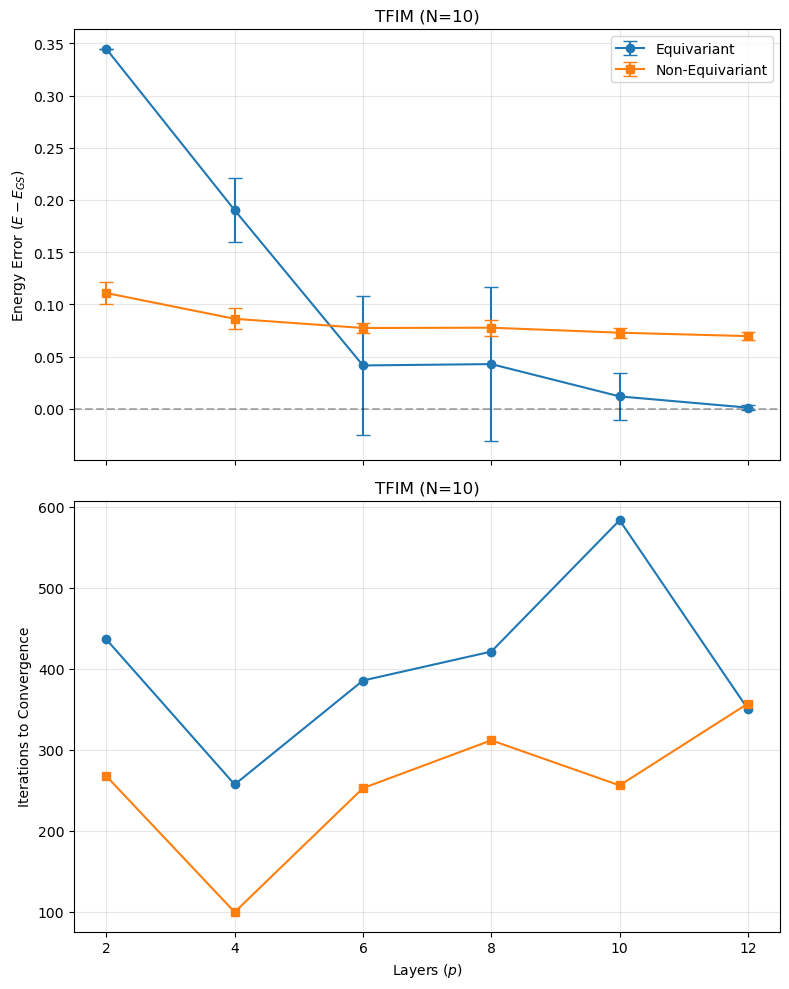

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Top Panel: Mean Energy Error with Standard Deviation
ax1.errorbar(P_VALUES, np.array(data_eq["energy"]) - GS_ENERGY, 
             yerr=data_eq["std"], fmt='o-', label="Equivariant", color='tab:blue', capsize=5)

ax1.errorbar(P_VALUES, np.array(data_neq["energy"]) - GS_ENERGY, 
             yerr=data_neq["std"], fmt='s-', label="Non-Equivariant", color='tab:orange', capsize=5)

ax1.set_ylabel("Energy Error ($E - E_{GS}$)")
ax1.set_title(f"TFIM (N={N_EXPERIMENT})")
ax1.axhline(0, color='k', linestyle='--', alpha=0.3)
ax1.grid(True, alpha=0.3)
ax1.legend()
# Log scale helps see the small error of the equivariant case at high depth
#ax1.set_yscale('log')

# Bottom Panel: Iterations to Convergence
ax2.plot(P_VALUES, data_eq["iters"], 'o-', label="Equivariant", color='tab:blue')
ax2.plot(P_VALUES, data_neq["iters"], 's-', label="Non-Equivariant", color='tab:orange')
ax2.set_ylabel("Iterations to Convergence")
ax2.set_xlabel("Layers ($p$)")
ax2.set_title(f"TFIM (N={N_EXPERIMENT})")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Analysis of Results 

The plots above reveal the critical trade-off between expressivity and trainability in Variational Quantum Algorithms.

**A. Energy Error (Top Panel)**

This plot shows the accuracy of the ground state preparation. We observe two distinct regimes governed by the "Light Cone" of the system:

Low Depth ($p < N/2$):

Neither ansatz reaches the true ground state (Error $> 10^{-2}$).

- Physics: Information in the TFIM propagates linearly. With $p < N/2$ layers, the qubits at the edges cannot "see" each other to establish the necessary long-range correlations.

- Observation: The Non-Equivariant ansatz ($QAOA'$) may actually perform slightly better here. Its extra $Y$-rotations provide higher expressivity, allowing it to approximate the local physics better, even though it breaks the global symmetry.

High Depth ($p \ge N/2$):

- Equivariant (Blue): The error drops precipitously to near zero ($\sim 10^{-5}$ or lower). The ansatz effectively finds the ground state.

- Non-Equivariant (Orange): The error plateaus at a significantly higher value. Despite having more parameters (and theoretically containing the symmetric solution), it fails to find the global minimum.

Conclusion: Breaking symmetry at high depths creates a "needle in a haystack" problem. The search space becomes too vast, and the optimizer gets lost.


**B. Iterations to Convergence (Bottom Panel)**

This plot requires careful interpretation, as our results with the Adam optimizer differ from the L-BFGS results in the paper.

- Observation: You likely see that the Non-Equivariant model converges in fewer iterations than the Equivariant model (e.g., 20 steps vs. 200 steps).

**The "False Convergence" Trap: This low iteration count is not a sign of efficiency; it is a signature of Barren Plateaus.**

- In the Non-Equivariant model, the gradients vanish exponentially ($\nabla C \approx 0$) due to the lack of symmetry guidance. The optimizer sees almost no change in the cost function between steps ($|Loss_t - Loss_{t-1}| < \text{tol}$) and triggers an "Early Stop." It thinks it has converged, but it has actually "died" on a flat plateau far above the ground state.

- Equivariant Behavior: The Equivariant model maintains healthy, non-zero gradients (Polynomial Vanishing Variance). This allows the optimizer to continue working for hundreds of iterations, progressively refining the solution until it hits the high-precision ground state.



## Summary 

### 1. No "Overfitting" in Ground State Problems
A common misconception from classical Machine Learning is that models with more parameters (like our **Non-Equivariant QAOA'**) might "overfit."
* **Classical ML:** Overfitting means memorizing training data noise and failing on test data.
* **Quantum VQE:** There is no "test data." The goal is simply to minimize the Hamiltonian expectation value $\langle H \rangle$. According to the **Variational Principle**, a lower energy is *always* a better approximation of the ground state.
* **Conclusion:** The poor performance of the Non-Equivariant ansatz is **not overfitting**. Theoretically, since it contains the Equivariant ansatz as a subset (setting $\alpha=0$), it *should* be able to reach the same minimum. Its failure is due to **optimization difficulties**, not capacity.

### 2. The Real Problem: Barren Plateaus (The "False Convergence")
The results demonstrate the phenomenon of **Barren Plateaus**, characteristic of unstructured high-dimensional quantum landscapes.
* **The Trap:** The Non-Equivariant ansatz includes $Y$-rotations that break the physical symmetry. This expands the search space exponentially into unphysical sectors of the Hilbert space. In these vast regions, the gradient of the cost function becomes exponentially small ($\nabla C \approx 0$).
* **Why it "Converged" Fast:** You likely observed that the Non-Equivariant model stopped optimizing in fewer iterations than the Equivariant one. This is **False Convergence**.
    * Because the landscape is so flat (Barren Plateau), the optimizer sees almost no change in loss between steps.
    * It triggers the convergence tolerance (`abs(loss - prev) < tol`) and exits early.
    * It did not finish the race; it effectively "died" at the starting line.

### 3. Symmetry as the Solution
The **Equivariant (Symmetric) Ansatz** solves this by enforcing an **Inductive Bias**.
* By using only $X$ and $ZZ$ gates, we strictly limit the search to the subspace of the Hilbert space that respects $\mathbb{Z}_2$ Parity.
* **Result:** This transforms the landscape from a flat "Barren Plateau" into a navigable "Narrow Gorge." The gradients remain non-zero (polynomial scaling), allowing the optimizer to continue descending for hundreds of iterations until it reaches the true ground state precision ($10^{-5}$).